In [ ]:
# --- TAHAP 1: DATA PREPARATION ---

# Impor pustaka dasar
import os, warnings, re, io, json, datetime
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Impor pustaka Scikit-learn (akan digunakan nanti)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Impor pustaka khusus (akan digunakan nanti)
from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
# from google.colab import files  <-- TIDAK DIPERLUKAN LAGI

# 1.a. Tentukan nama file Anda di sini
# PASTIKAN FILE INI ADA DI FOLDER YANG SAMA DENGAN NOTEBOOK ANDA
file_name = "dataset_clean_engineered (1).csv"  # <--- GANTI INI

# 1.b. Muat dataset dari file lokal
if not os.path.exists(file_name):
    print(f"Error: File '{file_name}' tidak ditemukan.")
    print("Pastikan file Excel Anda berada di folder yang sama dengan notebook ini.")
else:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' berhasil dimuat.")

    # 1.c. Normalisasi nama kolom
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^0-9a-z_]", "", regex=True)  # hapus karakter aneh
    )

    print(f"\nShape dataset: {df.shape}")
    print(f"Contoh nama kolom: {df.columns[:10].tolist()}")

File 'dataset_clean_engineered (1).csv' berhasil dimuat.

Shape dataset: (3421, 10)
Contoh nama kolom: ['age', 'gender', 'department', 'job_title', 'years_at_company', 'satisfaction_level', 'attrition', 'age_minus_tenure', 'maturity_satisfaction_interaction', 'loyalty_satisfaction_score']


Kolom target terdeteksi: attrition
Target berhasil dibinerisasi tanpa nilai hilang.

Nilai unik target: [0 1]
Distribusi target:
attrition
0    0.732
1    0.268
Name: proportion, dtype: float64

Head:
    age  gender   department job_title  years_at_company  satisfaction_level  \
0   27    Male    Marketing   Manager               9.0                0.59   
1   53  Female        Sales  Engineer              10.0                0.26   
2   59  Female    Marketing   Analyst               8.0                0.30   
3   42  Female  Engineering   Manager               1.0                0.48   
4   44  Female        Sales  Engineer              10.0                0.64   

   attrition  age_minus_tenure  maturity_satisfaction_interaction  \
0          0              18.0                              15.93   
1          0              43.0                              13.78   
2          1              51.0                              17.70   
3          0              41.0                 

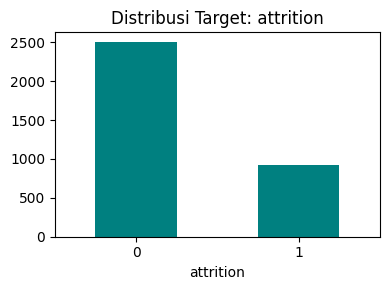

In [ ]:
# --- TAHAP 2: EXPLORATORY DATA ANALYSIS (EDA) ---

# 2.a. Deteksi kolom target otomatis
pattern = r"(^|_)attrition($|_)|(^|_)resign($|_)|(^|_)turnover($|_)|(^|_)quit($|_)|(^|_)churn($|_)"
target_candidates = [c for c in df.columns if re.search(pattern, c)]

if not target_candidates:
    raise ValueError("Kolom target tidak ditemukan. Coba cari kolom: attrition/resign/turnover/quit/churn.")
TARGET = target_candidates[0]
print("Kolom target terdeteksi:", TARGET)

# 2.b. Fungsi pemetaan target ke biner
def make_binary_target(s):
    if pd.api.types.is_numeric_dtype(s):
        uniq = sorted(pd.unique(s.dropna()))
        if len(uniq) == 2 and set(uniq) <= {0, 1}:
            return s.astype(int)
    ss = s.astype(str).str.strip().str.lower()
    mapping = {
        "yes": 1, "no": 0, "y": 1, "n": 0,
        "true": 1, "false": 0, "1": 1, "0": 0,
        "resigned": 1, "active": 0, "left": 1, "stayed": 0
    }
    mapped = ss.map(mapping)
    return mapped.astype("Int64")

# 2.c. Terapkan binerisasi target dan validasi
df[TARGET] = make_binary_target(df[TARGET])
if df[TARGET].isna().all():
    raise ValueError("Gagal memetakan target ke biner 0/1. Periksa nilai unik target.")
if df[TARGET].isna().sum() > 0:
    print(f"Peringatan: {df[TARGET].isna().sum()} baris target tidak bisa dipetakan.")
else:
    print("Target berhasil dibinerisasi tanpa nilai hilang.")
df[TARGET] = df[TARGET].astype("int8")

print(f"\nNilai unik target: {df[TARGET].unique()}")
print(f"Distribusi target:\n{df[TARGET].value_counts(normalize=True).round(3)}")

# 2.d. Tampilkan ringkasan data awal
print("\nHead:\n", df.head(5))
print("\nInfo:")
df.info()
print("\nDeskriptif numerik:\n", df.select_dtypes(include=np.number).describe().T)

# 2.e. Visualisasi Distribusi Target
plt.figure(figsize=(4,3))
df[TARGET].value_counts(dropna=False).sort_index().plot(kind="bar", color="teal")
plt.title(f"Distribusi Target: {TARGET}")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# --- TAHAP 3: DATA QUALITY ASSESSMENT ---

print("--- RINGKASAN DATA QUALITY (AWAL) ---")

# 3.a. Pisahkan tipe kolom untuk analisis
num_cols = [c for c in df.columns if c != TARGET and pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c != TARGET and df[c].dtype == "object"]
print(f"Kolom numerik: {len(num_cols)}, Kolom kategorik: {len(cat_cols)}")

# 3.b. Buat laporan Data Quality (DQ)
dq = {
    "n_rows": len(df),
    "n_cols": len(df.columns),
    "duplicate_rows": int(df.duplicated().sum()),
    "missing_total": int(df.isna().sum().sum()),
    "target_balance": df[TARGET].value_counts(dropna=False, normalize=True).round(3).to_dict()
}
dq["duplicate_pct"] = round(dq["duplicate_rows"] / dq["n_rows"] * 100, 2)
dq["is_target_imbalanced"] = max(dq["target_balance"].values()) > 0.8

print(f"\nRows: {dq['n_rows']} | Cols: {dq['n_cols']}")
print(f"Missing total: {dq['missing_total']}")
print(f"Duplicate rows: {dq['duplicate_rows']} ({dq['duplicate_pct']}%)")
print(f"Distribusi Target: {dq['target_balance']}")
print(f"Apakah target imbalanced? {dq['is_target_imbalanced']}")

# 3.c. Missing value detail
print("\nMissing per kolom (Top 10):\n", df.isna().sum().sort_values(ascending=False).head(10))

# 3.d. Laporan Outlier (IQR)
outlier_report = {}
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0 or pd.isna(iqr):
        outlier_count, outlier_pct = 0, 0
    else:
        low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
        mask = (df[col] < low) | (df[col] > high)
        outlier_count = int(mask.sum())
        outlier_pct = round(outlier_count / len(df) * 100, 2)
    outlier_report[col] = {"n_outliers": outlier_count, "pct_outliers": outlier_pct}

dq["outliers_iqr"] = outlier_report
print("\nLaporan Outlier (Contoh):\n", pd.DataFrame(outlier_report).T.sort_values("n_outliers", ascending=False).head(5))

--- RINGKASAN DATA QUALITY (AWAL) ---
Kolom numerik: 6, Kolom kategorik: 3

Rows: 3421 | Cols: 10
Missing total: 0
Duplicate rows: 2 (0.06%)
Distribusi Target: {0: 0.732, 1: 0.268}
Apakah target imbalanced? False

Missing per kolom (Top 10):
 age                                  0
gender                               0
department                           0
job_title                            0
years_at_company                     0
satisfaction_level                   0
attrition                            0
age_minus_tenure                     0
maturity_satisfaction_interaction    0
loyalty_satisfaction_score           0
dtype: int64

Laporan Outlier (Contoh):
                             n_outliers  pct_outliers
loyalty_satisfaction_score       230.0          6.72
age_minus_tenure                  10.0          0.29
years_at_company                   0.0          0.00
age                                0.0          0.00
satisfaction_level                 0.0          0.00


In [ ]:
# --- TAHAP 4: DATA CLEANING ---

print(f"Sebelum cleaning: {df.shape[0]} baris")

# 4.a. Trim spasi kategori
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan})

# 4.b. Drop duplikat
dupe_before = df.duplicated().sum()
if dupe_before > 0:
    df = df.drop_duplicates().reset_index(drop=True)
print(f"Duplikat dibuang: {dupe_before} baris")

# 4.c. Outlier capping (winsorize)
def cap_outliers_iqr(series, factor=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    if iqr == 0 or pd.isna(iqr):
        return series, 0
    low, high = q1 - factor * iqr, q3 + factor * iqr
    clipped = np.clip(series, low, high)
    n_changed = int((series != clipped).sum())
    return clipped, n_changed

outlier_summary = {}
continuous_cols = [c for c in num_cols if df[c].nunique() > 10]
for col in continuous_cols:
    capped, n_changed = cap_outliers_iqr(df[col])
    df[col] = capped
    outlier_summary[col] = n_changed
print(f"Jumlah outlier yang dikoreksi (Top 5):\n{pd.Series(outlier_summary).sort_values(ascending=False).head(5)}")

# 4.d. Missing value imputation
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# 4.e. Cek hasil cleaning
print("\n--- Setelah Cleaning ---")
print(f"Total baris: {df.shape[0]}")
print(f"Missing total: {int(df.isna().sum().sum())}")

# Update tipe kolom (jika ada perubahan)
num_cols = [c for c in df.columns if c != TARGET and pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c != TARGET and (df[c].dtype == "object" or str(df[c].dtype).startswith("category"))]
print(f"Total kolom numerik: {len(num_cols)}, kategorik: {len(cat_cols)}")

Sebelum cleaning: 3421 baris
Duplikat dibuang: 2 baris
Jumlah outlier yang dikoreksi (Top 5):
loyalty_satisfaction_score    228
age_minus_tenure               10
years_at_company                0
age                             0
satisfaction_level              0
dtype: int64

--- Setelah Cleaning ---
Total baris: 3419
Missing total: 0
Total kolom numerik: 6, kategorik: 3


In [ ]:
# --- TAHAP 5: FEATURE ENGINEERING ---

def find_col(pattern, columns):
    for c in columns:
        if re.search(pattern, c, re.IGNORECASE):
            return c
    return None

cols_lower = df.columns.tolist()

# 5.a. Deteksi kolom untuk rekayasa fitur
col_age = find_col(r'(^|_)age($|_)|umur', cols_lower)
col_years = find_col(r'(^|_)years(_|)at(_|)company($)|tenure|masa(_|)kerja', cols_lower)
col_sat = find_col(r'satisf|job(_|)satisf|satisfaction', cols_lower)
print(f"Deteksi kolom → age: {col_age}, years_at_company: {col_years}, job_satisfaction_level: {col_sat}")

created_cols = []

# 5.b. Buat fitur baru
if col_age and col_years:
    df["age_minus_tenure"] = (
        pd.to_numeric(df[col_age], errors="coerce") - pd.to_numeric(df[col_years], errors="coerce")
    )
    created_cols.append("age_minus_tenure")

if col_age and col_sat:
    df["maturity_satisfaction_interaction"] = (
        pd.to_numeric(df[col_age], errors="coerce") * pd.to_numeric(df[col_sat], errors="coerce")
    )
    created_cols.append("maturity_satisfaction_interaction")

if col_years and col_sat:
    df["loyalty_satisfaction_score"] = (
        pd.to_numeric(df[col_years], errors="coerce") * pd.to_numeric(df[col_sat], errors="coerce")
    )
    created_cols.append("loyalty_satisfaction_score")

# 5.c. Cek hasil dan imputasi fitur baru
if created_cols:
    print("\nFitur baru ditambahkan:", created_cols)
    # Imputasi fitur baru jika ada missing (hasil dari operasi pd.to_numeric)
    for col in created_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())
    print(df[created_cols].head())
    print(f"Missing di fitur baru: {df[created_cols].isna().sum().sum()}")
else:
    print("\nTidak ada fitur baru yang berhasil dibuat.")

Deteksi kolom → age: age, years_at_company: years_at_company, job_satisfaction_level: satisfaction_level

Fitur baru ditambahkan: ['age_minus_tenure', 'maturity_satisfaction_interaction', 'loyalty_satisfaction_score']
   age_minus_tenure  maturity_satisfaction_interaction  \
0              18.0                              15.93   
1              43.0                              13.78   
2              51.0                              17.70   
3              41.0                              20.16   
4              34.0                              28.16   

   loyalty_satisfaction_score  
0                        5.31  
1                        2.60  
2                        2.40  
3                        0.48  
4                        6.40  
Missing di fitur baru: 0


In [ ]:
# --- TAHAP 6: DATA VALIDATION ---

def validate_dataset(df, target, max_missing_ratio=0.8):
    report = {"passed": True, "checks": []}

    # 1. Target harus biner
    ok_target = set(pd.unique(df[target].dropna())) <= {0, 1}
    report["checks"].append(("target_binary", bool(ok_target)))
    report["passed"] &= bool(ok_target)

    # 2. Kolom tidak boleh semua missing
    for c in df.columns:
        if c == target: continue
        non_missing = df[c].notna().any()
        report["checks"].append((f"non_all_missing::{c}", bool(non_missing)))
        report["passed"] &= bool(non_missing)

    # 3. Missing value ratio (harus 0 setelah cleaning)
    max_miss = df.drop(columns=[target]).isna().mean().max()
    report["checks"].append(("all_features_imputed", max_miss == 0))
    report["passed"] &= (max_miss == 0)

    report["summary"] = {
        "rows": df.shape[0], "cols": df.shape[1],
        "missing_ratio_max_feature": round(max_miss, 3),
    }
    return report

# --- Eksekusi validasi ---
validation_report = validate_dataset(df, TARGET)

print("--- HASIL VALIDASI DATA AKHIR ---")
print("Validation Passed?", validation_report["passed"])
if not validation_report["passed"]:
    print("Ada kolom yang gagal validasi. Detail:")
    failed_checks = [check for check in validation_report["checks"] if not check[1]]
    print(pd.DataFrame(failed_checks, columns=["check", "passed"]))
else:
    print("Semua check lulus validasi. Data siap untuk preprocessing.")

--- HASIL VALIDASI DATA AKHIR ---
Validation Passed? True
Semua check lulus validasi. Data siap untuk preprocessing.


In [ ]:
# --- TAHAP 7: PREPROCESSING PIPELINE ---

# 7.a. Definisikan X (fitur) dan y (target)
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(int)

# 7.b. Perbarui daftar kolom (termasuk fitur baru)
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]
print(f"Definisi fitur: {len(num_cols)} numerik, {len(cat_cols)} kategorik.")

# 7.c. Kompatibilitas OneHotEncoder
encoder_kwargs = (
    {"handle_unknown": "ignore", "sparse_output": False}
    if sklearn.__version__ >= "1.2"
    else {"handle_unknown": "ignore", "sparse": False}
)

# 7.d. Definisikan pipeline numerik dan kategorik
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**encoder_kwargs))
])

# 7.e. Gabungkan dalam ColumnTransformer
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
], remainder="passthrough") # 'remainder' untuk jaga-jaga jika ada kolom terlewat

print("Pipeline preprocessing berhasil dibuat.")

Definisi fitur: 6 numerik, 3 kategorik.
Pipeline preprocessing berhasil dibuat.


In [ ]:
# --- TAHAP 8: DATA DRIFT DETECTION (FUNGSI) ---

def psi_score(expected, actual, bins=10):
    """Population Stability Index"""
    expected, actual = pd.Series(expected).dropna(), pd.Series(actual).dropna()
    if len(expected) < 30 or len(actual) < 30 or expected.nunique() <= 1:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(expected.quantile(quantiles))
    if len(cuts) <= 2: return np.nan
    actual = actual.clip(lower=expected.min(), upper=expected.max())
    e_counts, _ = np.histogram(expected, bins=cuts)
    a_counts, _ = np.histogram(actual, bins=cuts)
    e_perc = (e_counts + 1e-6) / e_counts.sum()
    a_perc = (a_counts + 1e-6) / a_counts.sum()
    psi = np.sum((a_perc - e_perc) * np.log(a_perc / e_perc))
    return round(float(psi), 4)

def ks_drift(ref, cur):
    """Kolmogorov–Smirnov test for numerical drift"""
    ref, cur = pd.Series(ref).dropna(), pd.Series(cur).dropna()
    if len(ref) < 30 or len(cur) < 30 or ref.nunique() <= 1 or cur.nunique() <= 1:
        return {"stat": 0.0, "p_value": 1.0}
    stat, p = ks_2samp(ref, cur)
    return {"stat": round(stat, 4), "p_value": round(p, 4)}

def categorical_drift_chi2(ref, cur):
    """Chi-square test for categorical drift"""
    vc_ref, vc_cur = ref.value_counts(), cur.value_counts()
    cats = sorted(set(vc_ref.index).union(vc_cur.index))
    ref_counts = np.array([vc_ref.get(c, 0) for c in cats])
    cur_counts = np.array([vc_cur.get(c, 0) for c in cats])
    if (ref_counts.sum() == 0) or (cur_counts.sum() == 0):
        return {"chi2": 0.0, "p_value": 1.0}
    chi2, p, _, _ = chi2_contingency([ref_counts, cur_counts])
    return {"chi2": round(chi2, 4), "p_value": round(p, 4)}

print("Fungsi-fungsi deteksi drift (PSI, KS, Chi2) siap digunakan.")

Fungsi-fungsi deteksi drift (PSI, KS, Chi2) siap digunakan.


In [ ]:
# --- TAHAP 9: TRAIN-TEST SPLIT & DRIFT CHECK ---

# 9.a. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"Data split: Train: {X_train.shape} | Test: {X_test.shape}")

# 9.b. Terapkan pipeline preprocessing
X_train_ready = preprocess.fit_transform(X_train)
X_test_ready = preprocess.transform(X_test)
print(f"Shape data ter-preprocess: Train: {X_train_ready.shape}, Test: {X_test_ready.shape}")

# 9.c. Eksekusi Deteksi Drift (Train vs Test)
print("\n--- DETEKSI DRIFT (TRAIN vs TEST) ---")
drift_report = {"numeric": {}, "categorical": {}}

# Numerik (PSI & KS)
for c in num_cols:
    psi_val = psi_score(X_train[c], X_test[c])
    ks_val = ks_drift(X_train[c], X_test[c])
    drift_report["numeric"][c] = {"PSI": psi_val, "KS_pvalue": ks_val["p_value"]}

# Kategorik (Chi2)
for c in cat_cols:
    chi_val = categorical_drift_chi2(X_train[c].astype(str), X_test[c].astype(str))
    drift_report["categorical"][c] = chi_val

# 9.d. Buat laporan ringkas drift
num_drift_df = (
    pd.DataFrame([{"feature": k, **v} for k, v in drift_report["numeric"].items()])
    .sort_values("PSI", ascending=False)
    .assign(flag_drift=lambda d: np.where(d["PSI"] > 0.25, "High", "OK"))
)
cat_drift_df = (
    pd.DataFrame([{"feature": k, "p_value": v["p_value"]} for k, v in drift_report["categorical"].items()])
    .sort_values("p_value")
    .assign(flag_drift=lambda d: np.where(d["p_value"] < 0.05, "Drift", "OK"))
)

# 9.e. Tampilkan hasil drift
print("\nTop 5 Drift Numerik (PSI tinggi):")
print(num_drift_df.head(5))
print("\nTop 5 Drift Kategorik (p-value kecil):")
print(cat_drift_df.head(5))

Data split: Train: (2564, 9) | Test: (855, 9)
Shape data ter-preprocess: Train: (2564, 31), Test: (855, 31)

--- DETEKSI DRIFT (TRAIN vs TEST) ---

Top 5 Drift Numerik (PSI tinggi):
                             feature     PSI  KS_pvalue flag_drift
2                 satisfaction_level  0.0311     0.2850         OK
4  maturity_satisfaction_interaction  0.0195     0.0912         OK
3                   age_minus_tenure  0.0141     0.3611         OK
0                                age  0.0065     0.8669         OK
1                   years_at_company  0.0047     0.6693         OK

Top 5 Drift Kategorik (p-value kecil):
      feature  p_value flag_drift
1  department   0.2737         OK
2   job_title   0.4190         OK
0      gender   0.4340         OK


In [15]:
# --- TAHAP 10: FINAL SUMMARIZATION (FIXED) ---

# 10.a. Buat ringkasan akhir pipeline
summary = {
    "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "rows_final": len(df),
    "cols_final": len(df.columns),
    "target": TARGET,
    "engineered_features": created_cols,
    "train_rows": X_train.shape[0],
    "test_rows": X_test.shape[0],
    "validation_passed": validation_report["passed"],
    "drift_flag": (
        (num_drift_df["PSI"] > 0.25).any() or (cat_drift_df["p_value"] < 0.05).any()
    ),
    "drift_numeric_top": num_drift_df.head(3).round(3).to_dict(orient="records"),
    "drift_categorical_top": cat_drift_df.head(3).round(3).to_dict(orient="records"),
}

# 10.b. Tambahkan flag interpretasi ke ringkasan
for row in summary["drift_numeric_top"]:
    row["flag_drift"] = "DRIFT" if row["PSI"] > 0.25 else "OK"
for row in summary["drift_categorical_top"]:
    row["flag_drift"] = "DRIFT" if row["p_value"] < 0.05 else "OK"

# --- TAHAP 10.b (BARU): HITUNG CLASS WEIGHT ---

    print("\n--- Menghitung Bobot Kelas (Class Weight) ---")
    # Hitung rasio untuk scale_pos_weight XGBoost
    # (Jumlah 'Stay') / (Jumlah 'Resign') di data latih (y_train)
    counts = np.bincount(y_train)

    # Pastikan ada kedua kelas
    if len(counts) < 2:
        print("Peringatan: Data latih hanya memiliki satu kelas. Tidak dapat menghitung bobot.")
        scale_pos_weight_value = 1
    else:
        scale_pos_weight_value = counts[0] / counts[1]
        print(f"Rasio 'Stay' (0) vs 'Resign' (1): {counts[0]} / {counts[1]}")
        print(f"Nilai scale_pos_weight untuk XGBoost: {scale_pos_weight_value:.4f}")

# 10.c. Fungsi pembersih JSON (untuk kompatibilitas tipe data NumPy)
# --- PINDAHKAN KE ATAS SINI ---
def clean_for_json(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    if isinstance(obj, (np.int64, np.int32, np.int16)):
        return int(obj)
    if isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    if isinstance(obj, dict):
        return {k: clean_for_json(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [clean_for_json(v) for v in obj]
    return obj

# 10.d. BERSIHKAN SUMMARY SEBELUM DICETAK
# --- PANGGIL FUNGSINYA SEKARANG ---
summary = clean_for_json(summary)

# 10.e. Sekarang aman untuk mencetak
print("\n=== PIPELINE SUMMARY ===")
print(json.dumps(summary, indent=4)) # <-- SEKARANG INI AKAN BERHASIL

# 10.f. Simpan semua artefak
df.to_csv("dataset_clean_engineered.csv", index=False)
num_drift_df.to_csv("numeric_drift_report.csv", index=False)
cat_drift_df.to_csv("categorical_drift_report.csv", index=False)

with open("pipeline_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("\nFile berhasil disimpan:")
print(" - dataset_clean_engineered.csv (Data bersih)")
print(" - numeric_drift_report.csv (Laporan drift numerik)")
print(" - categorical_drift_report.csv (Laporan drift kategorik)")
print(" - pipeline_summary.json (Ringkasan pipeline)")


--- Menghitung Bobot Kelas (Class Weight) ---
Rasio 'Stay' (0) vs 'Resign' (1): 1876 / 688
Nilai scale_pos_weight untuk XGBoost: 2.7267

--- Menghitung Bobot Kelas (Class Weight) ---
Rasio 'Stay' (0) vs 'Resign' (1): 1876 / 688
Nilai scale_pos_weight untuk XGBoost: 2.7267

--- Menghitung Bobot Kelas (Class Weight) ---
Rasio 'Stay' (0) vs 'Resign' (1): 1876 / 688
Nilai scale_pos_weight untuk XGBoost: 2.7267

=== PIPELINE SUMMARY ===
{
    "timestamp": "2025-11-05 04:08:46",
    "rows_final": 3419,
    "cols_final": 10,
    "target": "attrition",
    "engineered_features": [
        "age_minus_tenure",
        "maturity_satisfaction_interaction",
        "loyalty_satisfaction_score"
    ],
    "train_rows": 2564,
    "test_rows": 855,
    "validation_passed": true,
    "drift_flag": false,
    "drift_numeric_top": [
        {
            "feature": "satisfaction_level",
            "PSI": 0.031,
            "KS_pvalue": 0.285,
            "flag_drift": "OK"
        },
        {
        

MACHINE LEARNING PREDICTION

In [19]:
# --- (PERBAIKAN) IMPOR PUSTAKA UNTUK TAHAP 11-14 ---
# Impor ini ditambahkan di sini agar sel/section ini dapat berjalan mandiri
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
import numpy as np
import pandas as pd
# --- AKHIR PERBAIKAN ---


# --- TAHAP 11: PELATIHAN MODEL DASAR (BASELINE) ---

# 11.b. Definisikan model-model
models = {
    "Logistic Regression (Balanced)": LogisticRegression(
        random_state=42, max_iter=1000, class_weight='balanced'
    ),
    "Random Forest (Balanced)": RandomForestClassifier(
        random_state=42, class_weight='balanced', n_jobs=-1
    ),
    "XGBoost (Balanced)": XGBClassifier(
        random_state=42, use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=scale_pos_weight_value
    ),
    "LightGBM (Balanced)": LGBMClassifier(
        random_state=42, verbosity=-1, class_weight='balanced'
    )
}

results = []
print("\n--- MEMULAI PELATIHAN MODEL (BASELINE) ---")

# 11.c. Latih dan evaluasi setiap model
best_baseline_model = None
best_baseline_recall = -1.0
best_baseline_model_name = ""

for name, model in models.items():
    print(f"\n--- Melatih {name} ---")
    model.fit(X_train_ready, y_train)
    y_pred = model.predict(X_test_ready)
    y_pred_proba = model.predict_proba(X_test_ready)[:, 1]

    auc = roc_auc_score(y_test, y_pred_proba)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)

    print(f"Hasil untuk {name}:")
    print(f"ROC AUC Score: {auc:.4f}")
    print(f"Recall (Resign): {recall_1:.4f}")

    report_dict = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "Model": name,
        "ROC_AUC": auc,
        "Recall_Resign (1)": report_dict["1"]["recall"],
        "Precision_Resign (1)": report_dict["1"]["precision"]
    })

    # Simpan model baseline terbaik (berdasarkan Recall)
    if recall_1 > best_baseline_recall:
        best_baseline_recall = recall_1
        best_baseline_model_name = name
        best_baseline_model = model

# 11.d. Tampilkan ringkasan perbandingan
print("\n--- RINGKASAN PERBANDINGAN MODEL (BASELINE) ---")
results_df = pd.DataFrame(results).sort_values(by="Recall_Resign (1)", ascending=False)
print(tabulate(results_df, headers='keys', tablefmt='psql', floatfmt=".4f", showindex=False))
print(f"\nModel Baseline Terbaik (Recall): {best_baseline_model_name} (Recall: {best_baseline_recall:.4f})")


# --- TAHAP 12: HYPERPARAMETER TUNING UNTUK LOGISTIC REGRESSION ---

print("\n\n--- MEMULAI HYPERPARAMETER TUNING UNTUK LOGISTIC REGRESSION ---")
print("Mencari parameter terbaik untuk model juara bertahan...")

# Kita akan menyempurnakan Logistic Regression karena ini adalah model terbaik kita
logreg_to_tune = LogisticRegression(
    random_state=42,
    max_iter=2000, # Beri iterasi lebih banyak untuk solver 'saga'
    class_weight='balanced'
)

# Tentukan parameter yang ingin diuji
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Kekuatan regularisasi (inversi)
    'solver': ['liblinear', 'saga'], # Pilihan solver yang baik
    'penalty': ['l1', 'l2'] # Uji regularisasi L1 dan L2
}

# Kita ingin mencari model dengan RECALL (kelas 1) terbaik
recall_scorer = make_scorer(recall_score, pos_label=1)

# Siapkan GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg_to_tune,
    param_grid=param_grid,
    scoring=recall_scorer,  # <-- Fokus untuk memaksimalkan Recall 'Resign'
    cv=5,                   # 5-fold cross-validation
    n_jobs=-1,              # Gunakan semua core CPU
    verbose=1
)

# Latih!
grid_search.fit(X_train_ready, y_train)

print("\n--- HASIL TUNING ---")
print(f"Parameter Terbaik: {grid_search.best_params_}")
print(f"Skor Recall (CV) Terbaik: {grid_search.best_score_:.4f}")

# Simpan model terbaik yang sudah di-tuning
best_tuned_model = grid_search.best_estimator_


# --- TAHAP 13: EVALUASI MODEL YANG SUDAH DI-TUNE ---

print("\n\n--- EVALUASI FINAL MODEL TERBAIK (YANG SUDAH DI-TUNE) ---")

# Lakukan prediksi pada data UJI (X_test_ready)
y_pred_tuned = best_tuned_model.predict(X_test_ready)
y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_ready)[:, 1]

auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
recall_tuned_final = recall_score(y_test, y_pred_tuned, pos_label=1)

print(f"Model: Logistic Regression (Tuned)")
print(f"ROC AUC Score: {auc_tuned:.4f}")
print(f"F1-Score (Weighted): {f1_tuned:.4f}")
print("Classification Report Final:")
print(classification_report(y_test, y_pred_tuned, target_names=["Stay (0)", "Resign (1)"]))

# Bandingkan dengan baseline
print("\nPerbandingan Recall (Resign):")
print(f" - Recall LogReg (Baseline): {best_baseline_recall:.4f}")
print(f" - Recall LogReg (Tuned):    {recall_tuned_final:.4f}")


# --- TAHAP 14: PENGUJIAN MODEL SECARA MANUAL ---

print("\n\n--- PENGUJIAN MODEL SECARA MANUAL (MENGGUNAKAN MODEL TERBAIK) ---")

# Secara otomatis memilih model terbaik
final_model_to_use = best_baseline_model
final_model_name = best_baseline_model_name

# Bandingkan recall baseline terbaik dengan recall tuned
if recall_tuned_final > best_baseline_recall:
    final_model_to_use = best_tuned_model # Ini adalah model (Tuned)
    final_model_name = "Logistic Regression (Tuned)"
    print(f"Model (Tuned) lebih baik (Recall: {recall_tuned_final:.4f}) dan akan digunakan.")
else:
    print(f"Model (Baseline) '{final_model_name}' (Recall: {best_baseline_recall:.4f}) lebih baik dan akan digunakan.")

# Siapkan template
all_features = X.columns.tolist()
data_manual = pd.DataFrame(columns=all_features, index=[0])

# Isi data hipotetis
print("\n--- Mengisi Data Karyawan Hipotetis ---")
data_manual['age'] = 25
data_manual['satisfaction_level'] = 0.1  # Nilai kepuasan rendah
data_manual['department'] = 'Sales'
data_manual['years_at_company'] = 1
data_manual['gender'] = 'Female'
data_manual['job_title'] = 'Analyst'

print("\n--- Data Input Manual ---")
# Tampilkan hanya kolom yang diisi untuk kejelasan
filled_cols = [col for col in data_manual.columns if data_manual[col].notna().any()]
print(data_manual[filled_cols].T)

# Preprocessing & Prediksi
try:
    # Gunakan pipeline 'preprocess' yang sudah di-fit untuk mentransformasi data manual
    data_manual_prep = preprocess.transform(data_manual)

    pred = final_model_to_use.predict(data_manual_prep)
    proba = final_model_to_use.predict_proba(data_manual_prep)
    print("\nPrediksi data manual berhasil.")
except Exception as e:
    print(f"\nError saat prediksi: {e}")

# Tampilkan hasil prediksi
pred_label = "RESIGN (Resign)" if pred[0] == 1 else "STAY (Bertahan)"
proba_resign = proba[0][1]
proba_stay = proba[0][0]

print("\n--- HASIL PREDIKSI (MODEL FINAL TERBAIK) ---")
print(f"Model yang Digunakan: {final_model_name}")
print(f"Prediksi Model: {pred_label}")
print(f"Keyakinan (Probabilitas Resign): {proba_resign * 100:.2f}%")
print(f"Keyakinan (Probabilitas Stay):   {proba_stay * 100:.2f}%")


--- MEMULAI PELATIHAN MODEL (BASELINE) ---

--- Melatih Logistic Regression (Balanced) ---
Hasil untuk Logistic Regression (Balanced):
ROC AUC Score: 0.7084
Recall (Resign): 0.6435

--- Melatih Random Forest (Balanced) ---
Hasil untuk Random Forest (Balanced):
ROC AUC Score: 0.6855
Recall (Resign): 0.1478

--- Melatih XGBoost (Balanced) ---
Hasil untuk XGBoost (Balanced):
ROC AUC Score: 0.6641
Recall (Resign): 0.4217

--- Melatih LightGBM (Balanced) ---
Hasil untuk LightGBM (Balanced):
ROC AUC Score: 0.6778
Recall (Resign): 0.4957

--- RINGKASAN PERBANDINGAN MODEL (BASELINE) ---
+--------------------------------+-----------+---------------------+------------------------+
| Model                          |   ROC_AUC |   Recall_Resign (1) |   Precision_Resign (1) |
|--------------------------------+-----------+---------------------+------------------------|
| Logistic Regression (Balanced) |    0.7084 |              0.6435 |                 0.4315 |
| LightGBM (Balanced)            |   